In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ISLP.models import ModelSpec as MS
from ISLP import load_data
from ISLP.survival import sim_time
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test

c:\Users\admin\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
BrainCancer = load_data('BrainCancer')
BrainCancer.columns

Index(['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time'], dtype='object')

In [3]:
BrainCancer['status'].value_counts()

status
0    53
1    35
Name: count, dtype: int64

In [4]:
BrainCancer['time']

0     57.64
1      8.98
2     26.46
3     47.80
4      6.30
      ...  
83    20.69
84     6.39
85    32.82
86    42.07
87    13.90
Name: time, Length: 88, dtype: float64

<AxesSubplot:xlabel='timeline'>

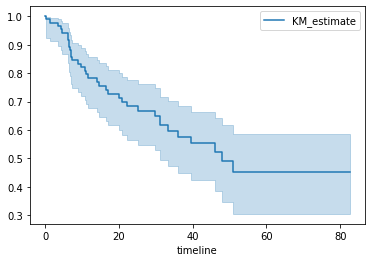

In [5]:
km = KaplanMeierFitter()
km_brain = km.fit(BrainCancer['time'], BrainCancer['status'])
km_brain.plot()

C:\Users\admin\AppData\Local\Temp\ipykernel_11680\2318599857.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for sex, df in BrainCancer.groupby('sex'):


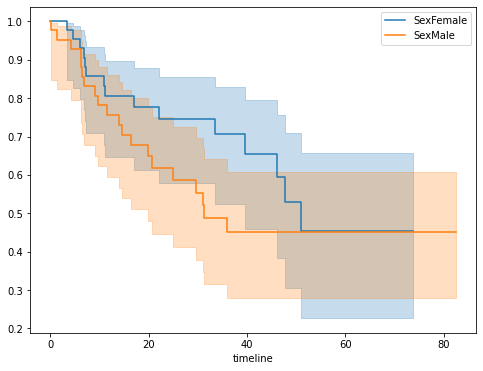

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
by_sex = {}
for sex, df in BrainCancer.groupby('sex'):
    by_sex[sex] = df
    km_sex = km.fit(df['time'], df['status'])
    km_sex.plot(label=f'Sex{sex}', ax=ax)

In [9]:
logrank_test(by_sex['Male']['time'], by_sex['Female']['time'], by_sex['Male']['status'], by_sex['Female']['status'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

In [13]:
coxph = CoxPHFitter()
sex_df = BrainCancer[['time', 'status', 'sex']]
model_df = MS(['time', 'status', 'sex'], intercept=False).fit_transform(sex_df)
cox_fit = coxph.fit(model_df, 'time', 'status')
cox_fit.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
sex[Male],0.407668,1.503309,0.342004,-0.262648,1.077984,0.769013,2.93875,0.0,1.191998,0.233262,2.099977


In [17]:
cox_fit.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

In [18]:
cleaned = BrainCancer.dropna()
all_MS = MS(cleaned.columns, intercept=False)
all_df = all_MS.fit_transform(cleaned)
fit_all = coxph.fit(all_df, 'time', 'status')
fit_all.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
sex[Male],0.183748,0.360358,0.610119
diagnosis[LG glioma],-1.239530,0.579555,0.032455
diagnosis[Meningioma],-2.154566,0.450524,0.000002
diagnosis[Other],-1.268870,0.617672,0.039949
loc[Supratentorial],0.441195,0.703669,0.530665
ki,-0.054955,0.018314,0.002693
gtv,0.034293,0.022333,0.124661
stereo[SRT],0.177778,0.601578,0.767597


In [19]:
levels = cleaned['diagnosis'].unique()
def representative(series):
    if hasattr(series.dtype, 'categories'):
        return pd.Series.mode(series)
    else:
        return series.mean()

model_data = cleaned.apply(representative, axis=0)
model_data

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621


In [23]:
model_df = pd.DataFrame([model_data.iloc[0] for _ in range(len(levels))])
model_df['diagnosis'] = levels
model_df

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621
0,Female,HG glioma,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621
0,Female,LG glioma,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621
0,Female,Other,Supratentorial,80.91954,8.687011,SRT,0.402299,27.188621


In [25]:
model_X = all_MS.transform(model_df)
model_X.index = levels
model_X

,sex[Male],diagnosis[LG glioma],diagnosis[Meningioma],diagnosis[Other],loc[Supratentorial],ki,gtv,stereo[SRT],status,time
Meningioma,0.0,0.0,1.0,0.0,1.0,80.91954,8.687011,1.0,0.402299,27.188621
HG glioma,0.0,0.0,0.0,0.0,1.0,80.91954,8.687011,1.0,0.402299,27.188621
LG glioma,0.0,1.0,0.0,0.0,1.0,80.91954,8.687011,1.0,0.402299,27.188621
Other,0.0,0.0,0.0,1.0,1.0,80.91954,8.687011,1.0,0.402299,27.188621


In [26]:
predicted_survival = fit_all.predict_survival_function(model_X)
predicted_survival

,Meningioma,HG glioma,LG glioma,Other
0.07,0.997947,0.982430,0.994881,0.995029
1.18,0.997947,0.982430,0.994881,0.995029
1.41,0.995679,0.963342,0.989245,0.989555
1.54,0.995679,0.963342,0.989245,0.989555
2.03,0.995679,0.963342,0.989245,0.989555
...,...,...,...,...
65.02,0.688772,0.040136,0.394181,0.404936
67.38,0.688772,0.040136,0.394181,0.404936
73.74,0.688772,0.040136,0.394181,0.404936
78.75,0.688772,0.040136,0.394181,0.404936


<AxesSubplot:>

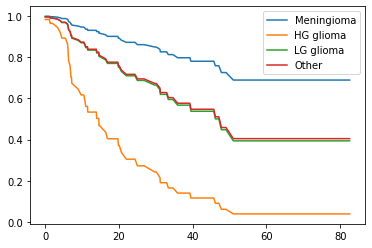

In [27]:
predicted_survival.plot()

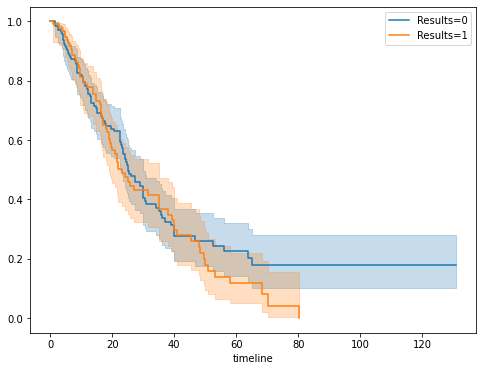

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
Publication = load_data('Publication')
by_result = {}
for result, df in Publication.groupby('posres'):
    by_result[result] = df
    km_result = km.fit(df['time'], df['status'])
    km_result.plot(label=f'Results={result}', ax=ax)

In [29]:
posres_df = MS(['posres', 'time', 'status'], intercept=False).fit_transform(Publication)
posres_fit = coxph.fit(posres_df, 'time', 'status')
posres_fit.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
posres,0.148076,0.161625,0.359579


In [30]:
model = MS(Publication.columns.drop('mech'), intercept=False).fit_transform(Publication)
model_fit = coxph.fit(model, 'time', 'status')
model_fit.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
posres,0.570773,0.175960,1.179610e-03
multi,-0.040860,0.251194,8.707842e-01
clinend,0.546183,0.262000,3.709944e-02
sampsize,0.000005,0.000015,7.507005e-01
budget,0.004386,0.002465,7.515984e-02
impact,0.058318,0.006676,2.426306e-18
